<a href="https://colab.research.google.com/github/cheeseleeeeena/text_classification_bert/blob/main/multiclass_text_classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Jul 31 12:04:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install transformers

In [36]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset

In [5]:
train_path = "/content/drive/MyDrive/Colab Notebooks/dataset/train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/dataset/test.csv"

In [6]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [9]:
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [11]:
train_df["Class Index"].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

In [ ]:
"""
The class labels are:

idx  cls
0    1: World
1    2: Sports
2    3: Business
3    4: Sci/Tech
"""

In [14]:
labeling = {
    1:0,
    2:1,
    3:2,
    4:3
}

In [15]:
train_df['Class Index'] = train_df['Class Index'].apply(lambda x : labeling[x])
test_df['Class Index'] = test_df['Class Index'].apply(lambda x: labeling[x])

In [17]:
test_df.head()

,Class Index,Title,Description
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


<Axes: xlabel='Class Index', ylabel='count'>

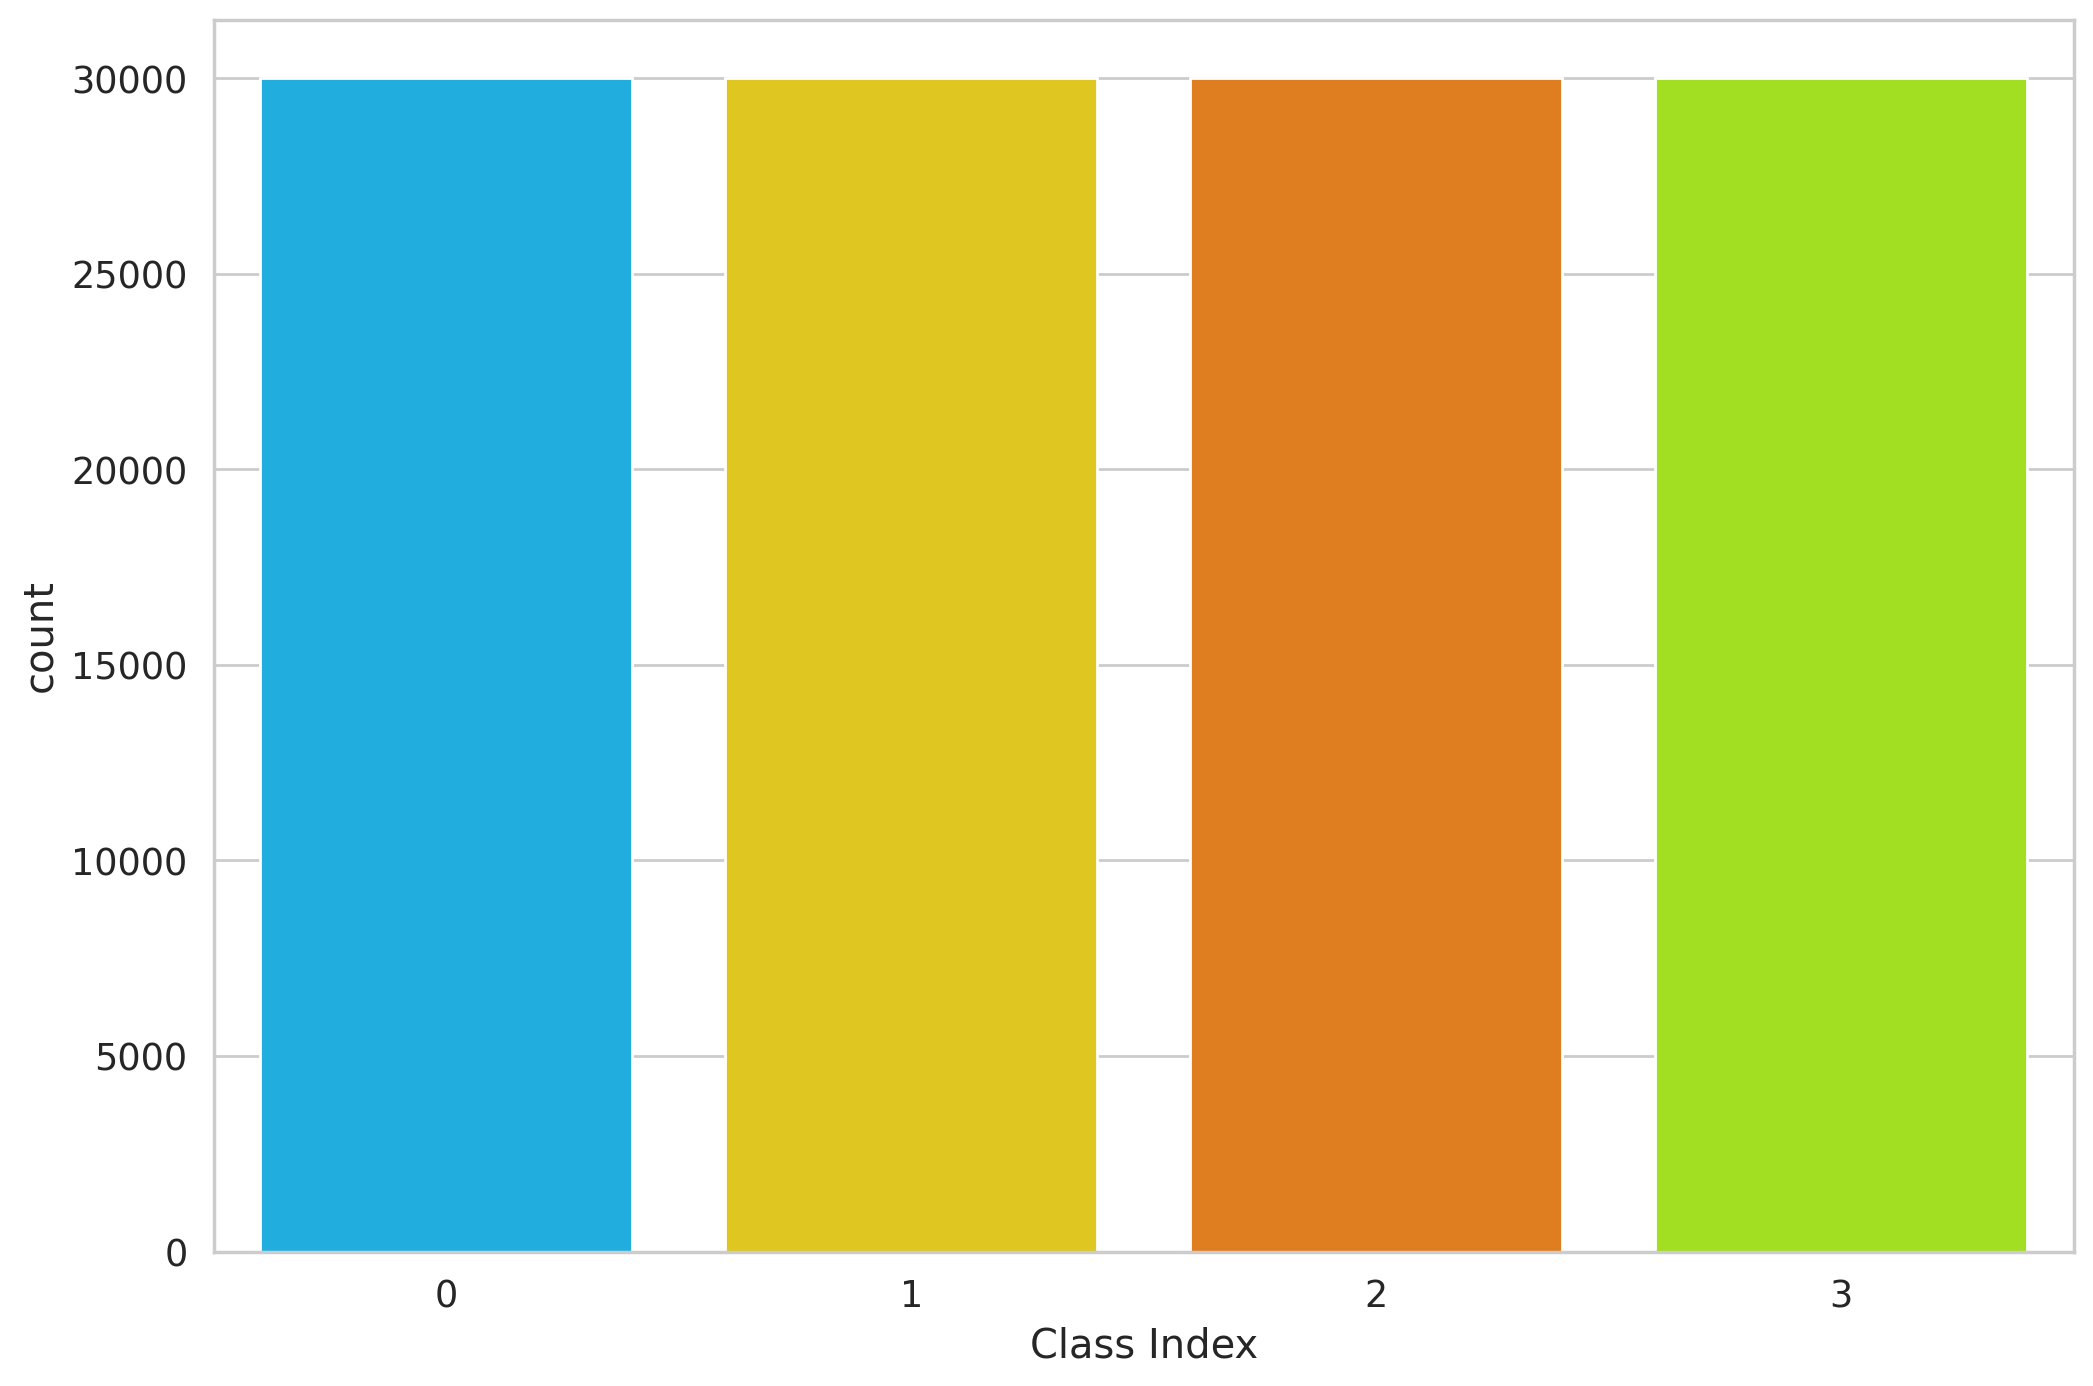

In [27]:
sns.countplot(x ='Class Index', data = train_df)

# Data Preprocessing

In [30]:
pre_trained_model_name = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name)

In [32]:
# Choosing Sequence Length
token_lens = []
train_df['content'] = train_df['Title'] + ' ' + train_df['Description']
del train_df['Title']
del train_df['Description']

for txt in train_df.content:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

In [ ]:
# set the background style of the plot

sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token Count')


In [67]:
X_input_ids = np.zeros((len(train_df), 256))
X_attn_masks = np.zeros((len(train_df), 256))

In [68]:
X_input_ids.shape

(120000, 256)

In [69]:
# MAX_LEN = 256

def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['content'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding="max_length",
            truncation = True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [70]:
X_input_ids, X_attn_masks = generate_training_data(train_df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [71]:
X_input_ids

array([[  101.,  6250.,  1457., ...,     0.,     0.,     0.],
       [  101., 19879.,  1513., ...,     0.,     0.,     0.],
       [  101.,  9105.,  1105., ...,     0.,     0.,     0.],
       ...,
       [  101., 17784.,  7167., ...,     0.,     0.,     0.],
       [  101.,  3570.,   112., ...,     0.,     0.,     0.],
       [  101., 20820.,  1116., ...,     0.,     0.,     0.]])

In [72]:
labels = np.zeros((len(train_df), 4))
labels.shape

(120000, 4)

In [73]:
labels[np.arange(len(train_df)), train_df['Class Index'].values] = 1 # one-hot encoded target tensor

In [74]:
labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [75]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [76]:
def DatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [77]:
dataset = dataset.map(DatasetMapFunction) # converting to required format for tensorflow dataset

In [78]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [79]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [80]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 4), dtype=tf.float64, name=None))>

In [81]:
p = 0.8
train_size = int((len(train_df)//16)*p)
# for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

print(train_size)

6000


In [82]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [83]:
len(train_dataset), len(val_dataset)

(6000, 1500)

#Model

In [64]:
from transformers import TFBertModel

In [65]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [84]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

my_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         multiple             108310272   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 intermediate_layer (Dense)     (None, 512)          393728      ['bert[1][1]']             

In [86]:
"""
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
"""

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_function = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [87]:
my_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [88]:
hist = my_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1
)

6000/6000 [==============================] - 5284s 879ms/step - loss: 0.2179 - accuracy: 0.9245 - val_loss: 0.1760 - val_accuracy: 0.9384


In [89]:
my_model.save('my_multiclass_bert')

# Prediction

In [102]:
test_df.shape

(7600, 3)

In [103]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB


In [104]:
test_df.head(10)

,Class Index,Title,Description
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
5,3,Open Letter Against British Copyright Indoctri...,The British Department for Education and Skill...
6,3,Loosing the War on Terrorism,"\\""Sven Jaschan, self-confessed author of the ..."
7,3,"FOAFKey: FOAF, PGP, Key Distribution, and Bloo...",\\FOAF/LOAF and bloom filters have a lot of i...
8,3,E-mail scam targets police chief,"Wiltshire Police warns about ""phishing"" after ..."
9,3,"Card fraud unit nets 36,000 cards","In its first two years, the UK's dedicated car..."


In [107]:
test_df['content'] = test_df['Title'] + ' ' + test_df['Description']
del test_df['Title']
del test_df['Description']

In [ ]:
test_df.head(5)

In [96]:
my_multiclass_bert = tf.keras.models.load_model('my_multiclass_bert')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

## Another way?

In [114]:
input_ids = np.zeros((len(train_df), 256))
attn_masks = np.zeros((len(train_df), 256))

def prepare_data2(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['content'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding="max_length",
            truncation = True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return {
        'input_ids': ids,
        'attention_mask': masks
        }

def make_prediction2(model, processed_data,
                    class_index=['1', '2', '3', '4']):
    results = model.predict(processed_data, batch_size=20)
    pred_class_index = []
    for prob in results:
      idx = class_index[np.argmax(prob)]
      pred_class_index.append(idx)
    return pred_class_index

In [ ]:
processed_data = prepare_data2(test_df, input_ids, attn_masks, tokenizer)
pred_class_index = make_prediction2(my_multiclass_bert, processed_data=processed_data)

## Brutal Force

In [99]:
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data,
                    class_index=['1', '2', '3', '4'],
                    class_names=['World','Sports','Business', 'Sci/Tech']):
    probs = model.predict(processed_data)[0]
    class_idx = class_index[np.argmax(probs)]
    class_name = class_names[np.argmax(probs)]
    return class_idx, class_name

In [ ]:
# exec time: 27min

pred_class_index = []
class_names = []

for txt in test_df.content:
    processed_data = prepare_data(txt, tokenizer)
    index, name = make_prediction(my_multiclass_bert, processed_data=processed_data)
    pred_class_index.append(index)
    class_names.append(name)

test_df['Predicted Class'] = pred_class_index
test_df['Predicted Class Names'] = class_names

# Evaluation



In [117]:
test_df.head(5)

,Class Index,content,Predicted Class,Predicted Class Names
0,3,Fears for T N pension after talks Unions repre...,3,Business
1,4,The Race is On: Second Private Team Sets Launc...,4,Sci/Tech
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...,4,Sci/Tech
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...,4,Sci/Tech
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,4,Sci/Tech


In [116]:
reverse_labeling = {
    0:1,
    1:2,
    2:3,
    3:4
}

test_df['Class Index'] = test_df['Class Index'].apply(lambda x: reverse_labeling[x])

In [127]:
test_df = test_df.astype({"Class Index": int, "Predicted Class": int})

In [128]:
y_test = list(test_df["Class Index"])
y_pred = list(test_df["Predicted Class"])

In [135]:
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4']))

              precision    recall  f1-score   support

           1       0.95      0.95      0.95      1900
           2       0.97      0.99      0.98      1900
           3       0.94      0.86      0.90      1900
           4       0.88      0.94      0.91      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



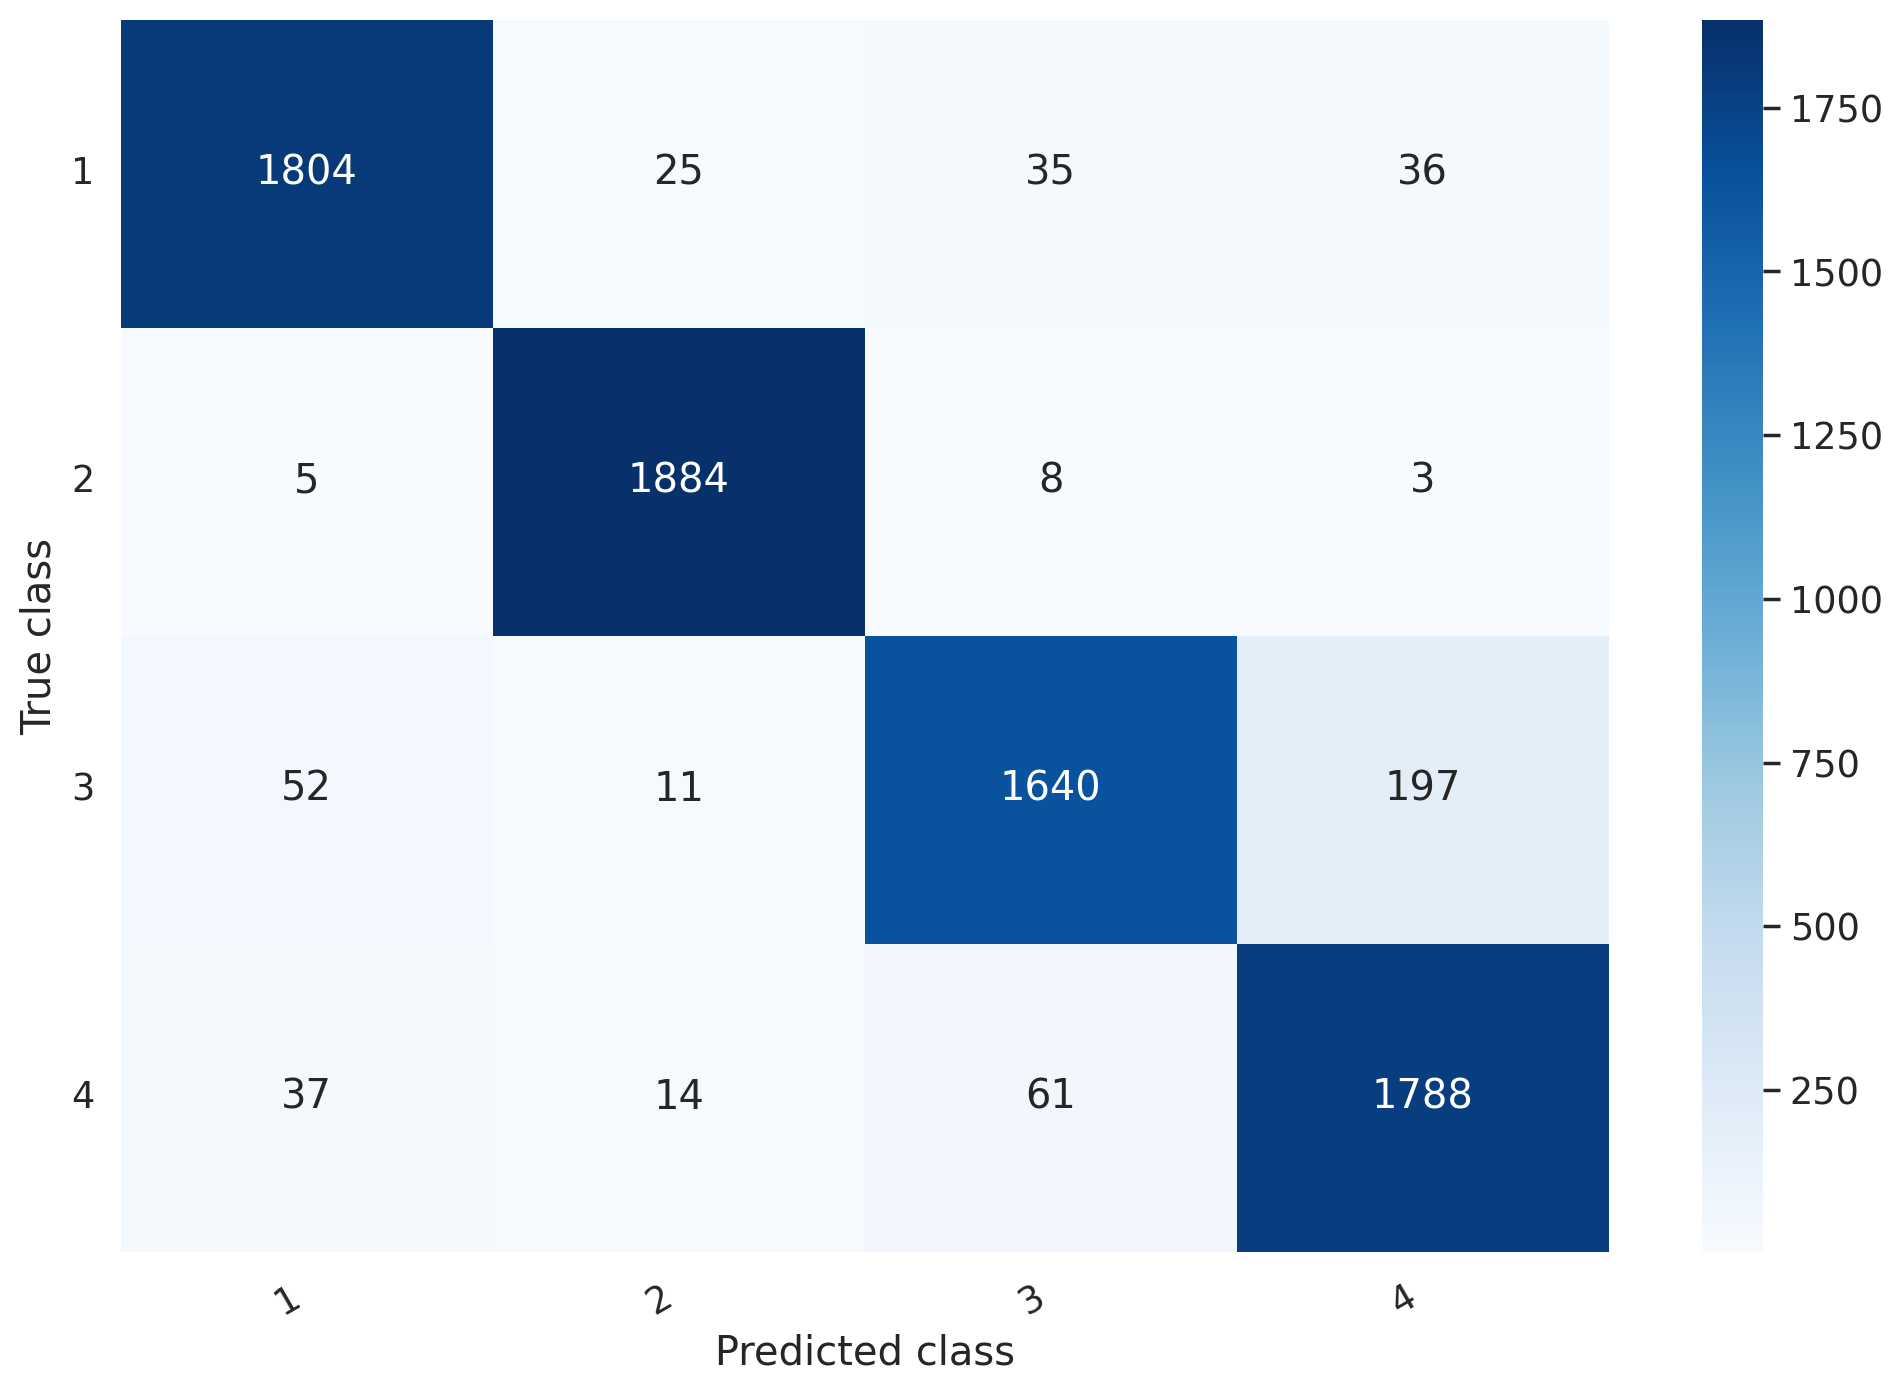

In [137]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['1', '2', '3', '4'], columns=['1', '2', '3', '4'])
show_confusion_matrix(df_cm)

In [143]:
input_text = """
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
"""

processed_data = prepare_data(input_text, tokenizer)
index, name = make_prediction(my_multiclass_bert, processed_data=processed_data)
print(f'Raw text: {input_text}')
print(f'Predicted index: {index}')
print(f'Predicted class: {name}')

1/1 [==============================] - 0s 108ms/step
Raw text: 
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second	eam of rocketeers competing for the #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.

Predicted index: 4
Predicted class: Sci/Tech
